# 보고서
## 선택한 데이터셋의 data point 개수 및 feature 개수
- data point 개수: 210
- feature 개수: 7

## 다양한 데이터 전처리 방법 비교
- 데이터 전처리 방법: MinMaxScaler, StandardScaler, RobustScaler
### 원본(Original) 데이터셋
- StandardScaler: 0.773
- No Scaling: 0.717
- MinMaxScaler: 0.705
### 특성 공학(Feature Engineered) 데이터셋
- MinMaxScaler: 0.690
- StandardScaler: 0.688
- No Scaling: 0.679
### 결론
- StandardScaler > MinMaxScaler 이유  
  StandardScaler는 평균을 0, 표준편차를 1로 변환하여 모든 특징이 동일한 스케일을 갖도록 합니다. MinMaxScaler는 각 특징의 최소값과 최대값을 기준으로 0~1의 값으로 변환하여 스케일을 맞추지만, 이상치에 민감합니다. 따라서, StandardScaler가 더 안정적인 성능을 보입니다.
  따라서 이번 데이터셋의 경우는 정규분포에 가깝고 분산이 중요한 특지잉었다고 판단할 수 있습니다.

- No Scaling이 부진한 이유: 스케일 지배 현상  
  K-Means는 거리를 계산할 때 값의 범위가 큰 특징(예: 면적)이 범위가 작은 특징(예: 콤팩트함)보다 훨씬 큰 영향력을 갖게 됩니다. 만약 작은 범위의 특징이 클래스 구분에 중요하더라도, 큰 범위 특징에 묻혀버리게 됩니다. 스케일링은 이러한 불균형을 해소하여 모든 특징이 공평하게 고려되도록 돕기 때문에, 스케일링을 한 경우가 대부분 더 좋은 성능을 보입니다.

## 클러스터 개수에 따른 평가지표 추이 확인
[ARI 평가 섹션](#8-ari-평가)에서 확인할 수 있듯 K=3일 때 가장 높은 성능을 보입니다.

## Feature engineering의 활용에 따른 성능 개선 확인
성능은 오히려 떨어졌습니다. 이는 기존 특징들이 이미 강력한 정보를 포함하고 있거나, 새로 추가된 특징이 기존 정보와 중복되거나 노이즈로 작용했을 가능성을 시사합니다.

## 2차원 시각화를 통한 최적의 클러스터링 결과 확인
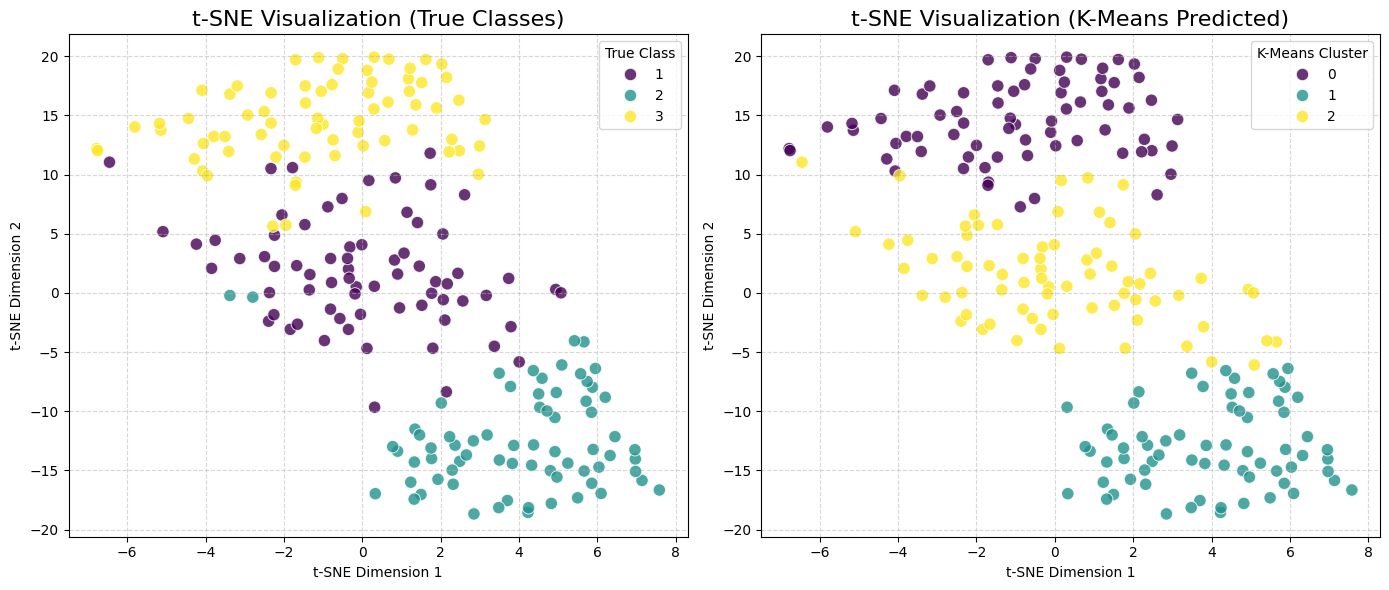
[t-SNE 시각화 섹션](#t-sne-시각화)에서 확인할 수 있듯, K=3일 때 가장 잘 구분된 클러스터를 확인할 수 있습니다.


## 추가 성능 개선 및 적절한 클러스터링 성능 평가를 위한 방안 논의
향후 성능 개선을 위해서는 EDA 기반의 정교한 특성 선택/공학과 K-Means의 한계를 보완할 수 있는 다른 클러스터링 알고리즘 적용을 고려해야 합니다. 또한, 정답이 없는 실제 상황을 대비해 t-SNE 시각화의 심층적인 해석을 통해 클러스터링 결과의 의미를 파악하는 것이 중요합니다.

## 1. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


## 2. 데이터 불러오기

In [2]:
columns = [
    'area', 'perimeter', 'compactness', 'kernel_length',
    'kernel_width', 'asymmetry_coeff', 'kernel_groove_length', 'class'
]

df = pd.read_csv("./seeds_dataset.txt", sep=r'\s+', header=None, names=columns)

## 3. 데이터 확인

In [3]:
print("\n데이터셋 정보:")
df.info()

print("\n데이터셋 앞부분 5개:")
print(df.head())

print("\n데이터셋 통계 요약:")
print(df.describe())

print("\n클래스별 데이터 개수:")
print(df['class'].value_counts())


데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area                  210 non-null    float64
 1   perimeter             210 non-null    float64
 2   compactness           210 non-null    float64
 3   kernel_length         210 non-null    float64
 4   kernel_width          210 non-null    float64
 5   asymmetry_coeff       210 non-null    float64
 6   kernel_groove_length  210 non-null    float64
 7   class                 210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB

데이터셋 앞부분 5개:
    area  perimeter  compactness  kernel_length  kernel_width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324    

## 4. Feature Engineering 적용

In [4]:
df_fe = df.copy() # 원본 데이터 복사

df_fe['length_width_ratio'] = df_fe['kernel_length'] / df_fe['kernel_width']
df_fe['area_perimeter_ratio'] = df_fe['area'] / df_fe['perimeter']
df_fe['kernel_area_approx'] = df_fe['kernel_length'] * df_fe['kernel_width']

print("\n특성 공학 후 데이터셋 (앞부분 5개):")
print(df_fe.head())


특성 공학 후 데이터셋 (앞부분 5개):
    area  perimeter  compactness  kernel_length  kernel_width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   asymmetry_coeff  kernel_groove_length  class  length_width_ratio  \
0            2.221                 5.220      1            1.740036   
1            1.018                 4.956      1            1.666367   
2            2.699                 4.825      1            1.585556   
3            2.259                 4.805      1            1.575614   
4            1.355                 5.175      1            1.588433   

   area_perimeter_ratio  kernel_area_approx  
0              1.028302           19.087056  
1              1.021277           18.511482  
2              1.014

## 5. EDA


Pair Plot 생성 중... (시간이 걸릴 수 있습니다)


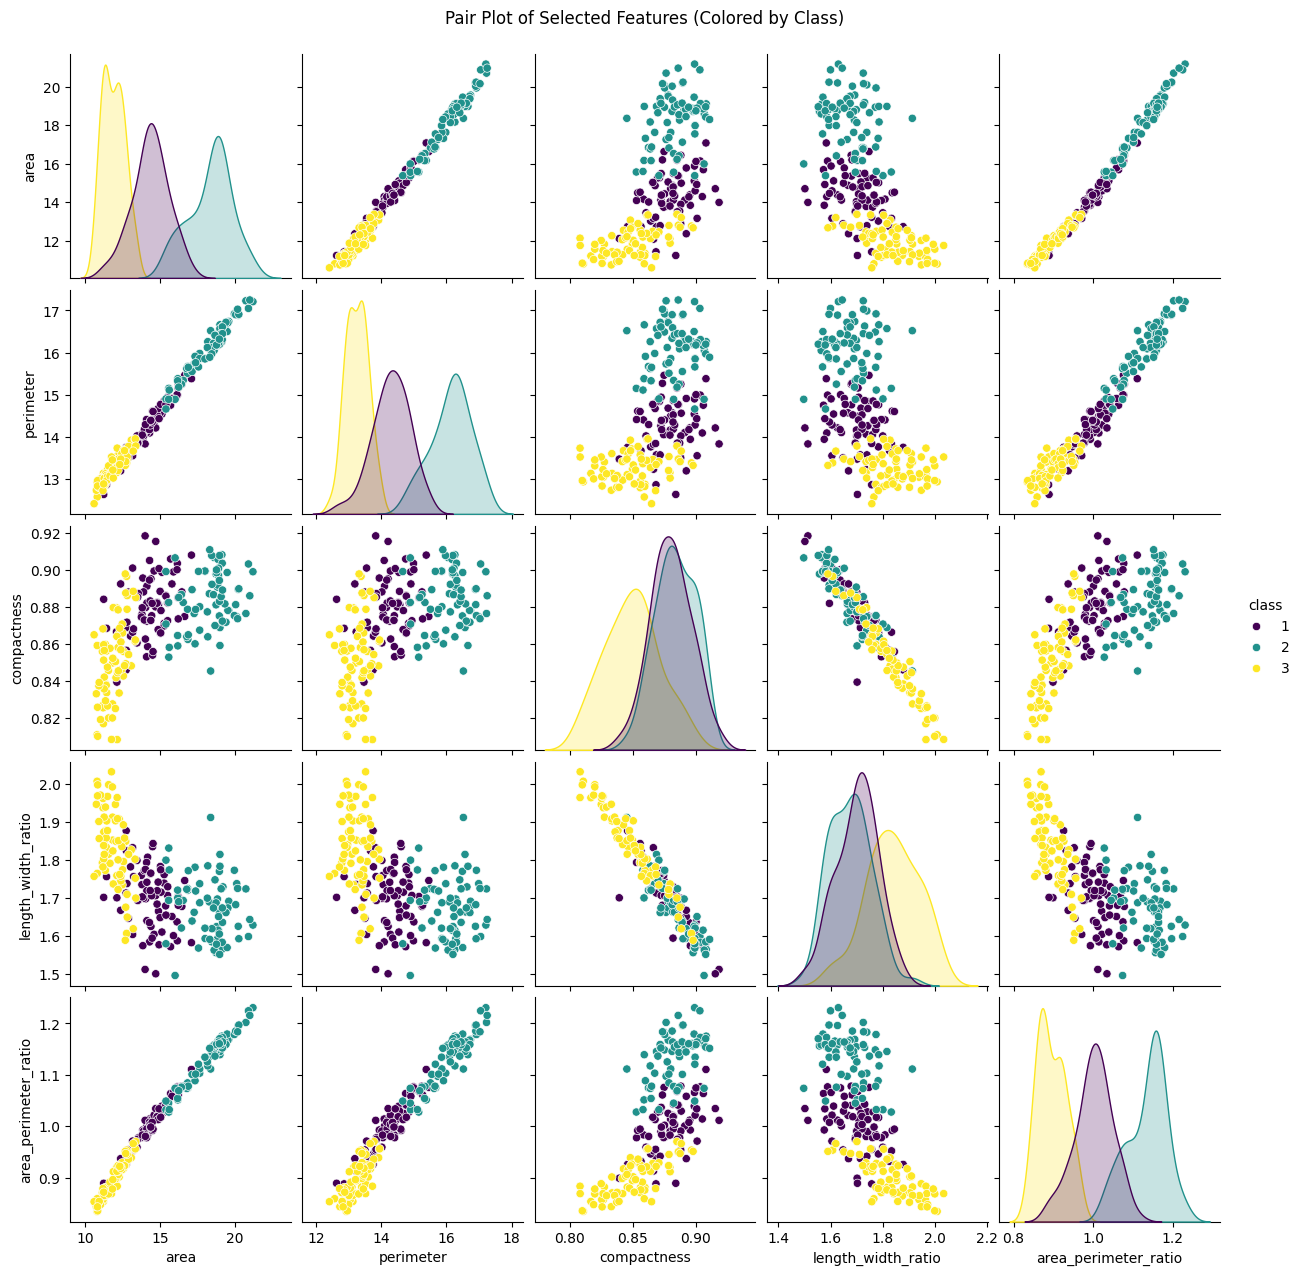

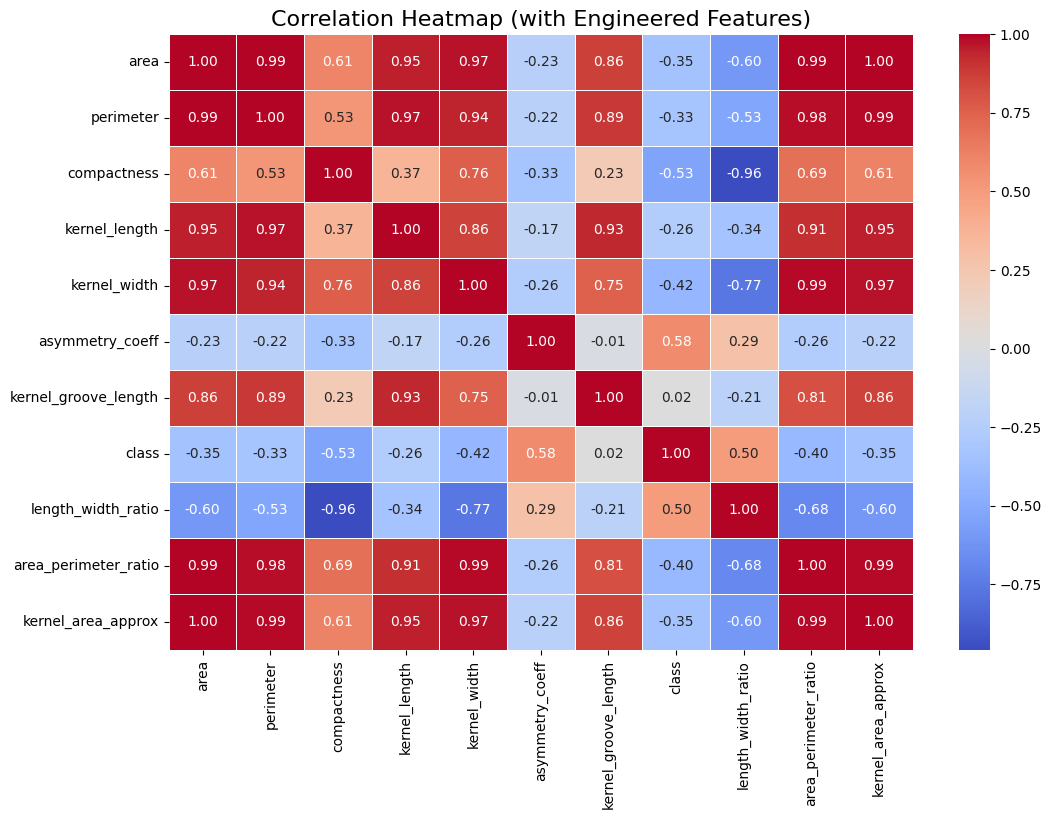

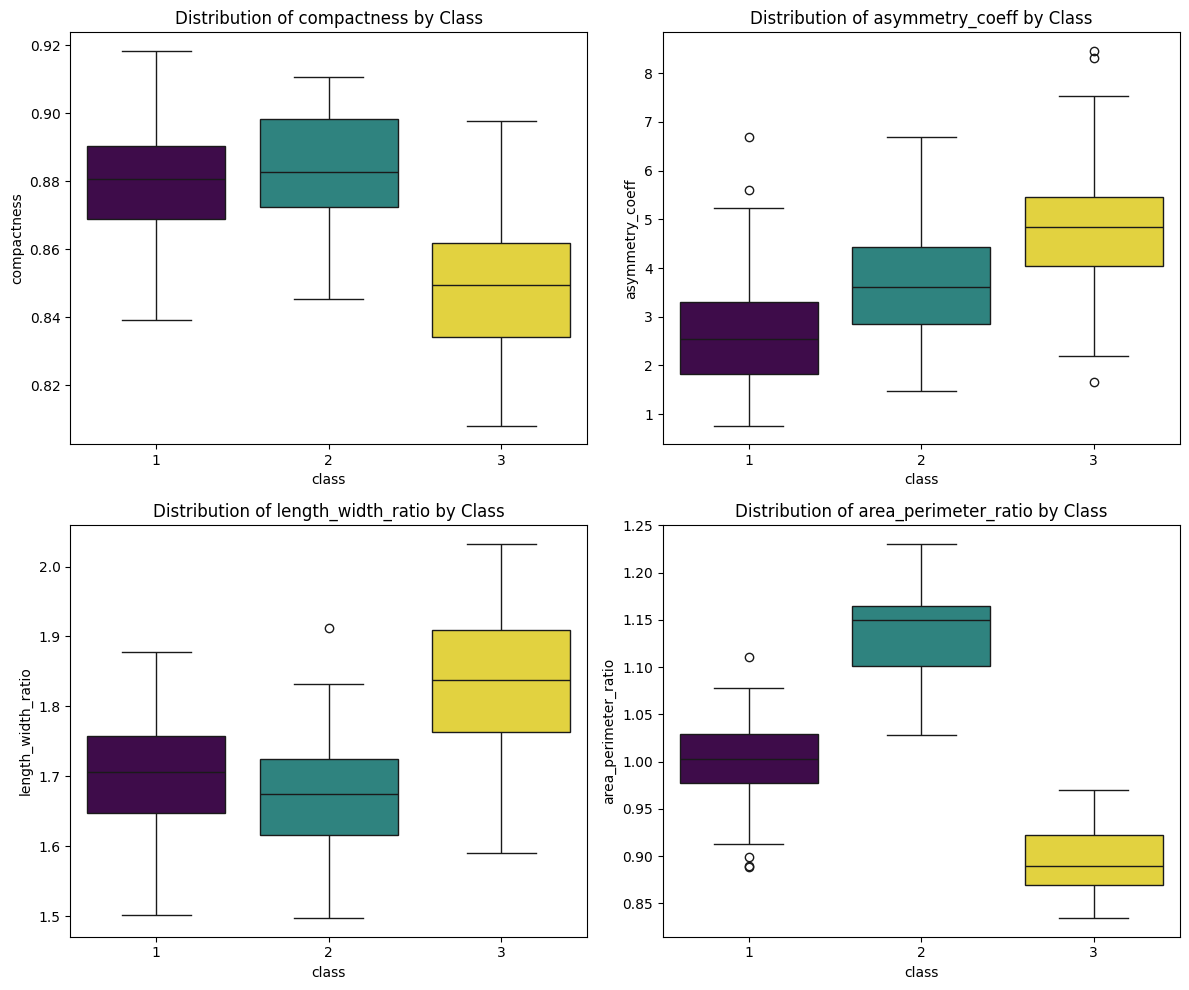

In [7]:
# --- 5. 탐색적 데이터 분석 (EDA) with Feature Engineering ---

# 5.1 Pair Plot (특성 간 관계 시각화)
selected_features = ['area', 'perimeter', 'compactness', 'length_width_ratio', 'area_perimeter_ratio', 'class']
sns.pairplot(df_fe[selected_features], hue='class', palette='viridis')
plt.suptitle("Pair Plot of Selected Features (Colored by Class)", y=1.02)
plt.show()

# 5.2 Correlation Heatmap (상관관계 히트맵)
plt.figure(figsize=(12, 8))
corr = df_fe.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap (with Engineered Features)', fontsize=16)
plt.show()

# 5.3 Box Plots (클래스별 특성 분포)
features_to_plot = ['compactness', 'asymmetry_coeff', 'length_width_ratio', 'area_perimeter_ratio']
n_cols = 2
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(12, n_rows * 5))
for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='class', y=feature, hue='class', data=df_fe, palette='viridis', legend=False)
    plt.title(f'Distribution of {feature} by Class')
plt.tight_layout()
plt.show()

## 6. 데이터셋 준비

In [22]:
X_orig = df.drop("class", axis=1)  # 정답 제거
X_fe = df_fe.drop("class", axis=1)  # 정답 제거
y_true = df["class"]  # 정답 레이블

datasets = {"Original": X_orig, "Feature Engineered": X_fe}
scalers = {
    "No Scaling": None,
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
}

X_scaled = {}

for d_name, data in datasets.items():
    for s_name, scaler in scalers.items():
        key = f"{d_name}_{s_name}"
        if scaler:
            X_scaled[key] = scaler.fit_transform(data)
        else:
            X_scaled[key] = data.values

## 7. 모델링

In [32]:
results = []

# K 값 범위 설정: 2~10
k_range = range(2, 11)

RANDOM_STATE = 2019313647

# 각 전처리된 데이터에 대해 K-Means 실행
for key, data in X_scaled.items():
    for k in k_range:
        # K-Means 모델 생성 및 학습
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        kmeans.fit(data)

        # 예측된 레이블
        pred_labels = kmeans.labels_

        # ARI 점수 계산 (K-Means 레이블은 0부터 시작, y_true는 1부터 시작.
        # ARI 계산에는 문제 없으나, 혼동 방지 위해 알아두세요)
        ari_score = adjusted_rand_score(y_true, pred_labels)

        # 결과 저장
        results.append(
            {
                "Data_Type": key.split("_")[0] + " " + key.split("_")[1],
                "Scaling": key.split("_")[-1],
                "K": k,
                "ARI": ari_score,
            }
        )

results_df = pd.DataFrame(results)

## 8. ARI 평가

In [33]:
print("\n--- ARI 평가 결과 ---")
results_df = results_df.sort_values(by='ARI', ascending=False)
print(results_df)


--- ARI 평가 결과 ---
                            Data_Type         Scaling   K       ARI
10            Original StandardScaler  StandardScaler   3  0.773294
1                 Original No Scaling      No Scaling   3  0.716620
19              Original MinMaxScaler    MinMaxScaler   3  0.704861
46    Feature Engineered MinMaxScaler    MinMaxScaler   3  0.689570
37  Feature Engineered StandardScaler  StandardScaler   3  0.687784
28      Feature Engineered No Scaling      No Scaling   3  0.678869
11            Original StandardScaler  StandardScaler   4  0.662449
29      Feature Engineered No Scaling      No Scaling   4  0.628673
20              Original MinMaxScaler    MinMaxScaler   4  0.624568
2                 Original No Scaling      No Scaling   4  0.596180
38  Feature Engineered StandardScaler  StandardScaler   4  0.590303
21              Original MinMaxScaler    MinMaxScaler   5  0.579507
47    Feature Engineered MinMaxScaler    MinMaxScaler   4  0.568910
48    Feature Engineered MinM

## 9. t-SNE 시각화


최적 데이터: Original_StandardScaler, 최적 K: 3


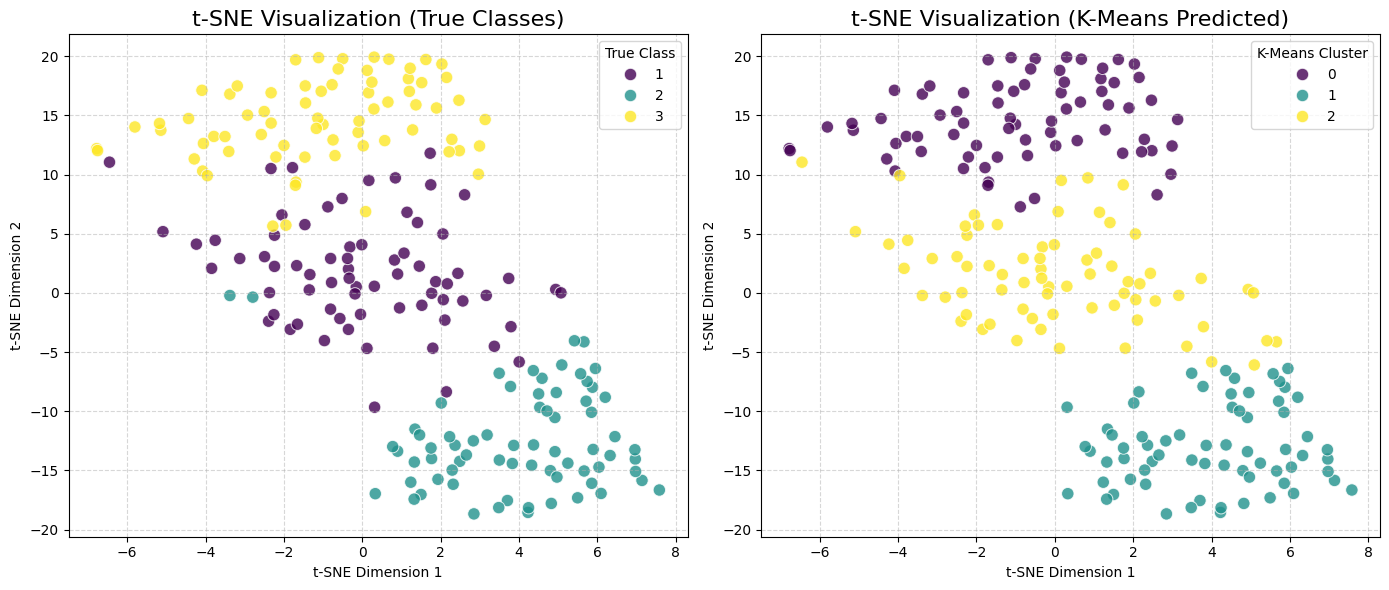

In [28]:
# 9.1 최적 데이터 및 K 선택
best_data_key = "Original_StandardScaler"
best_k = 3
best_data = X_scaled[best_data_key]

print(f"\n최적 데이터: {best_data_key}, 최적 K: {best_k}")

# 9.2 최적 K-Means 모델 학습 및 예측
kmeans_best = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
pred_labels_best = kmeans_best.fit_predict(best_data)

# 9.3 t-SNE 실행 (perplexity는 데이터 수나 특성에 따라 조절 가능)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_tsne = tsne.fit_transform(best_data)

# 9.4 시각화용 데이터프레임 생성
df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['true_class'] = y_true # 실제 클래스 추가
df_tsne['kmeans_pred'] = pred_labels_best # K-Means 예측 추가

# 9.5 시각화 (실제 vs 예측)
plt.figure(figsize=(14, 6))

# subplot 1: 실제 클래스 기준 시각화
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_tsne, x='tsne_1', y='tsne_2', hue='true_class',
    palette='viridis', s=80, alpha=0.8
)
plt.title('t-SNE Visualization (True Classes)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='True Class')
plt.grid(True, linestyle='--', alpha=0.5)

# subplot 2: K-Means 예측 기준 시각화
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_tsne, x='tsne_1', y='tsne_2', hue='kmeans_pred',
    palette='viridis', s=80, alpha=0.8
)
plt.title('t-SNE Visualization (K-Means Predicted)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='K-Means Cluster')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()